# Exploración de datos

Vamos a analizar el dataset sucio para identificar problemas en los datos. Para ello, realizaremos los siguientes pasos en **ambos datasets (`train` y `test`)** de manera conjunta:

1. Mostramos un fragmento aleatorio del dataset (7 filas) para observar su estructura.
2. Verificamos los valores mínimos y máximos en cada columna para detectar posibles valores fuera de rango.
3. Buscamos valores faltantes en todas las características.
4. Identificamos filas duplicadas en el dataset.

In [2]:
import pandas as pd
import sys
sys.path.append("..\src")
from utils import data_info
df_dev = pd.read_csv("../data/raw/casas_dev.csv")
df_test = pd.read_csv("../data/raw/casas_test.csv")
data_info(df_dev, df_test)

Fragmento aleatorio
        area area_units  is_house  has_pool   age   price        lat  \
751  1087.0       sqft         0         0   5.0   762.0  40.672593   
17    134.0         m2         0         1   5.0   488.0 -34.604883   
776   893.0       sqft         0         0  14.0   589.0  40.670955   
326   667.0       sqft         0         0   4.0   470.0  40.667657   
781  1722.0       sqft         1         0  12.0  1480.0  40.743194   
365   872.0       sqft         0         0   NaN   618.0  40.709343   
633   678.0       sqft         0         0   NaN   454.0  40.705211   

           lon  rooms  
751 -73.970156    3.0  
17  -58.379281    4.0  
776 -73.996371    2.0  
326 -73.997993    2.0  
781 -74.018666    NaN  
365 -73.992028    2.0  
633 -74.049206    2.0  

Rango de valores de cada columna
        area  is_house  has_pool   age   price        lat        lon  rooms
min    40.0       0.0       0.0   1.0    65.0 -34.686302 -74.058238    1.0
max  2164.0       1.0       1.0  

Del análisis previo, detectamos que la variable `area` tiene unidades inconsistentes. Primero, unificamos las unidades de la variable `area`, convirtiendo los valores expresados en **sqft** a **m²**. Luego, eliminamos la columna `area_units`, ya que no aporta información relevante.

Además, observamos que las propiedades están ubicadas en dos zonas bien diferenciadas según las coordenadas `lat` y `lon`. Para simplificar esta información, transformaremos estas dos variables en una única categoría que represente la zona. Dado que la representación categórica puede ser problemática para modelos numéricos, codificaremos esta nueva variable de forma binaria, asignando 0 a una zona y 1 a la otra.

También identificamos valores faltantes en las siguientes variables:  

- `age`, con **146 valores faltantes**.  
- `rooms`, con **76 valores faltantes**.  

En lugar de imputarlos directamente, primero analizaremos la relación entre las variables mediante un **pairplot**, un **boxplot** y un **countplot** comparativo. Esto nos permitirá visualizar posibles patrones en los valores faltantes y definir la mejor estrategia para completarlos.  

Además, exploraremos cómo varían ciertas características según la **zona**, lo que nos ayudará a entender si algunas propiedades son más comunes en determinadas áreas y cómo esto influye en la imputación.

No se encontraron valores fuera de rango ni filas duplicadas en el dataset.  

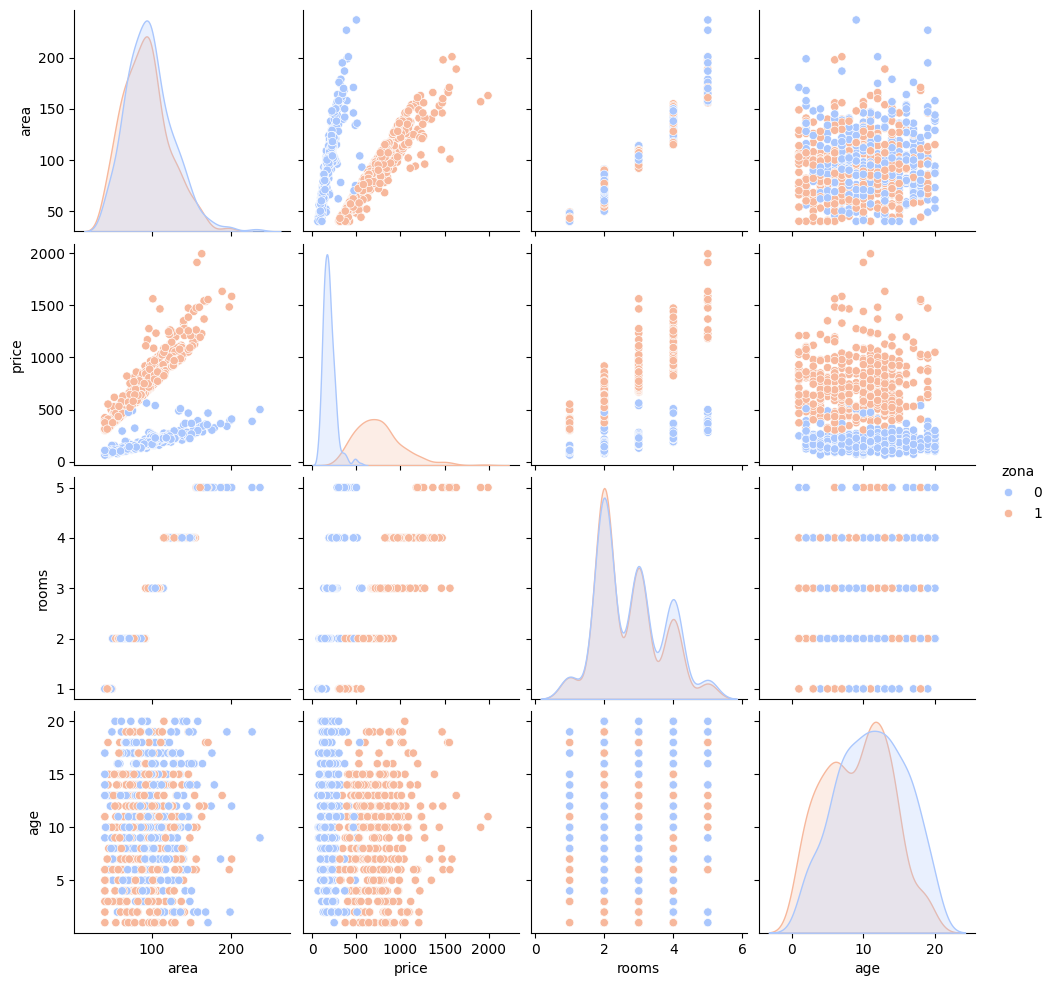

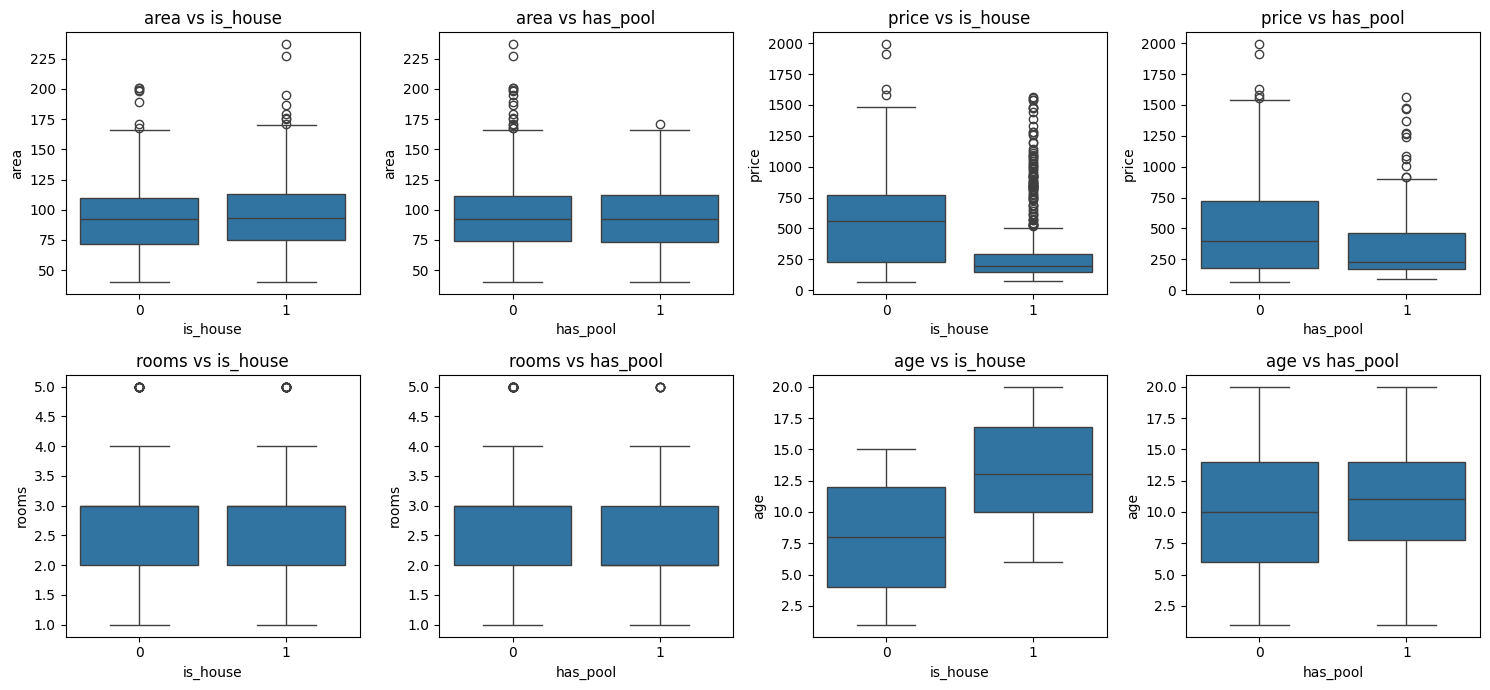

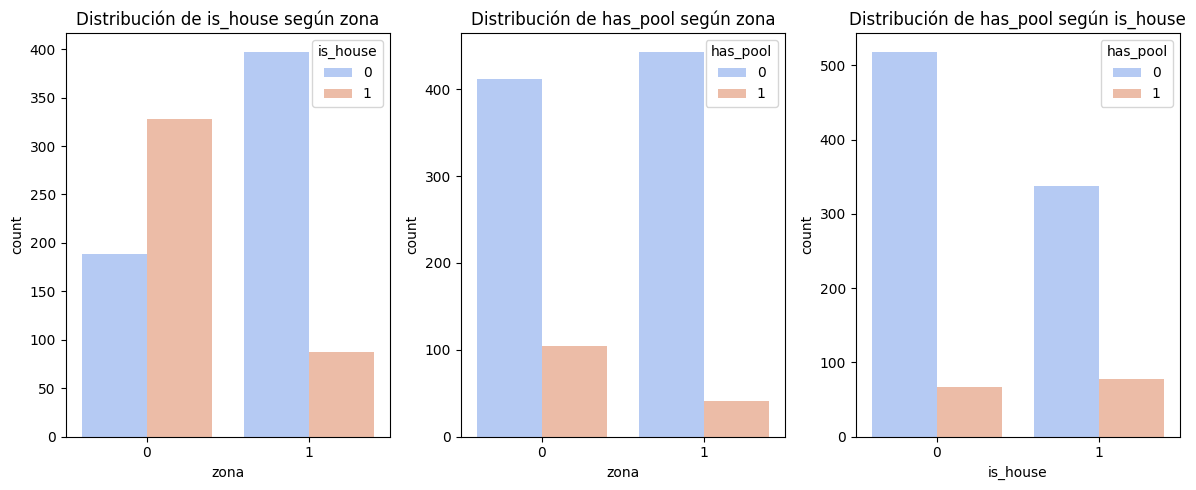

In [3]:
from preprocessing import convert_areaunits, one_hot_encoder
from utils import data_analisis

convert_areaunits(df_dev)
convert_areaunits(df_test)
one_hot_encoder(df_dev)
one_hot_encoder(df_test)
data_analisis(df_dev, df_test)


Al observar las relaciones, podemos definir estrategias para rellenar valores faltantes:  

- **NaNs en `rooms`**: Existe un patrón claro entre `rooms` y `area`, donde cada rango de área tiende a corresponder con un número específico de habitaciones. Podemos imputar los valores de `rooms` en función del área.  
- **NaNs en `age`**: La variable `is_house` influye en `age`, ya que las casas son generalmente más antiguas y los departamentos más nuevos. Podemos estimar `age` en función de `is_house`.  

Estas observaciones nos permiten una imputación de datos más precisa basada en patrones reales del conjunto de datos.  

Además de estas relaciones que nos ayudan a manejar NaNs, identificamos más relaciones entre variables que serán útiles más adelante:  

- **A mayor área, mayor precio**. Sin embargo, el impacto del área en el precio varía según la ubicación:  
  - En la **Zona 0**, el área aumenta poco, pero un pequeño aumento en el área significa un incremento significativo en el precio.  
  - En la **Zona 1**, el área aumenta más, pero un incremento en unidades de área no se traduce en un aumento proporcional del precio.  
- **Las casas suelen ser más baratas que los departamentos**, aunque algunas casas pueden superar en precio a varios departamentos. Lo mismo ocurre con la variable `has_pool`, aunque con un efecto mucho menor. Esto podría deberse a que las casas, en general, tienden a ser menos modernas o de mayor antigüedad.
- **El precio aumenta con la cantidad de habitaciones (`rooms`)**, pero esto está condicionado por la ubicación, dado que las casas del sur suelen ser mas caras que las del norte.
- **En la Zona 0, las viviendas tienden a ser casas**, mientras que en la Zona 1 predominan los departamentos. Además, **dos tercios de las viviendas con piscina están ubicadas en la Zona 0**, lo que sugiere que esta característica es más común en esa área.


En general, estas relaciones muestran que las variables tienen una fuerte correlación con el precio, lo que respalda su uso como etiquetas para el modelo.

In [4]:
from preprocessing import handle_missing_values
df_dev = handle_missing_values(df_dev)
df_test = handle_missing_values(df_test)

#Guardamos datos procesados
df_dev.to_csv("../data/processed/casas_dev_processed.csv", index=False)
df_test.to_csv("../data/processed/casas_test_processed.csv", index=False)


Para preparar los datos para el entrenamiento del modelo, primero se divide el conjunto de datos `casas_dev.csv` en dos subconjuntos:  
- **80% para entrenamiento (`dx_train`, `dy_train`)**  
- **20% para validación (`dx_val`, `dy_val`)**  

La variable objetivo (`y`) será el **precio de las propiedades**, según el análisis previo de las variables. 

Luego, se normalizan los datos de entrada (`dx_train` y `dx_val`) para mejorar el condicionamiento numérico de los algoritmos de aprendizaje.

In [5]:
from data_splitting import train_val_split
from preprocessing import normalize
dx = df_dev.drop(columns=["price"])
dy = df_dev["price"]
dx_train, dx_val, dy_train, dy_val = train_val_split(dx, dy, 0.8)
xn_train, xn_val, media, desv = normalize(dx_train, dx_val)

## Aplicación de Modelos de Regresión

Comenzaremos a modelar la regresión lineal con un primer enfoque que use solo una característica: **el `área` de la propiedad**. Esto nos permitirá analizar su impacto en la predicción del precio y evaluar la precisión del modelo con una única variable antes de incorporar más información.  

Para ello, implementamos una **clase de regresión lineal** que permite entrenar el modelo utilizando tanto la **`pseudoinversa`** como **`gradiente descendiente`**, lo que nos permitirá comparar ambos métodos en el análisis de resultados.  

Además, utilizamos la **`función de Error Cuadrático Medio (MSE)`** para medir el desempeño del modelo. Esta métrica nos ayuda a cuantificar la precisión de las predicciones y comparar la efectividad de los distintos enfoques de entrenamiento.


--- Comparación de métodos ---

Gradiente Descendiente:
MSE Train: 105707.49295436605 | MSE Validation: 96292.98001283388


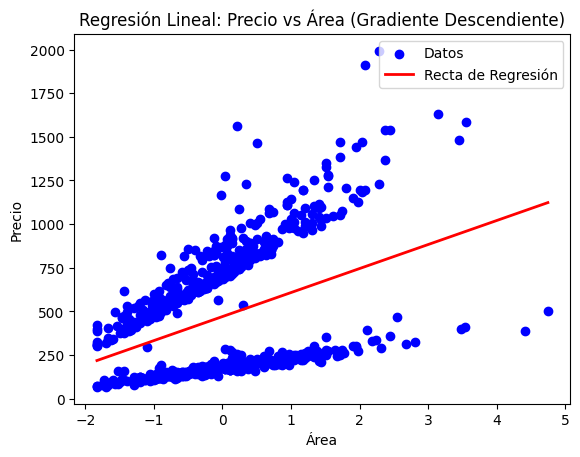


Pseudoinversa:
MSE Train: 105707.49295436605 | MSE Validation: 96292.98006516682


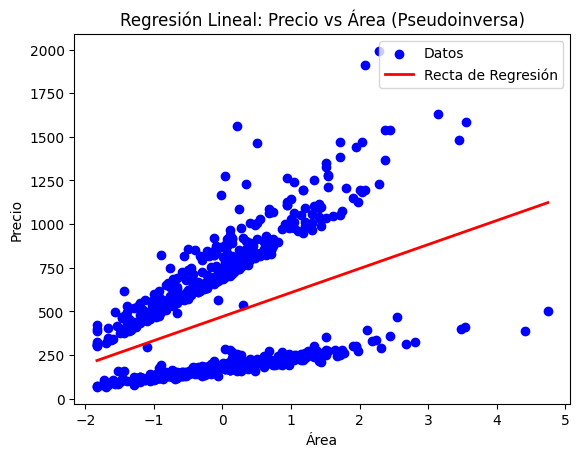

In [6]:
from utils import model_onefeature
model_onefeature(xn_train[["area"]], dy_train, xn_val[["area"]], dy_val)

El modelo que usa solo el **área de la propiedad** tiene un **MSE alto (96292)**, algo esperable al trabajar con una única variable.  

Como vimos en el análisis de variables previo, el **valor del metro cuadrado cambia mucho según la ubicación**. Esto hace que los datos se agrupen en dos zonas bien diferenciadas. La **recta de regresión** queda justo en el medio de ambas, lo que explica su falta de precisión.  

Tanto la **pseudoinversa (pinv)** como el **gradiente descendente (gd)** dan resultados similares, con errores parecidos. La falta de más información hace que el modelo no pueda ajustar bien los valores.  

Ahora entrenaremos un nuevo modelo incluyendo **más características importantes** para ver cuánto mejora la precisión y qué información aportan al resultado. Además, intentaremos **predecir el precio de una vivienda**.  


In [7]:
from utils import metricas
amanda = pd.read_csv("../data/raw/vivienda_Amanda.csv")
convert_areaunits(amanda)
one_hot_encoder(amanda)
amanda = handle_missing_values(amanda)
amanda = (amanda - media) / desv
metricas(xn_train, dy_train, xn_val, dy_val, amanda)




--- Comparación de métodos ---

Gradiente descendiente:
MSE Train: 15925.5166 | MSE Validation: 12819.8100
RMSE Train: 126.1963 | RMSE Validation: 113.2246
MAE Train: 90.8031 | MAE Validation: 86.6965
Predicción de price: [795.49139706]

Pseudoinversa:
MSE Train: 15888.8686 | MSE Validation: 12826.7275
RMSE Train: 126.0511 | RMSE Validation: 113.2551
MAE Train: 90.1977 | MAE Validation: 86.5049
Predicción de price: [796.38750815]


Los resultados muestran una **mejora considerable en la precisión** del modelo al incorporar más características. El **MSE se reduce notablemente**, lo que indica que las predicciones se acercan más a los valores reales de `dy_val`.  

El **RMSE** (raíz del error cuadrático medio) nos da una medida del error promedio en las mismas unidades que `dy_val`, facilitando la interpretación. El **MAE** (error absoluto medio) muestra el error promedio sin considerar valores elevados que puedan influir demasiado en la media. En ambos casos, la reducción de sus valores indica que el modelo es más preciso.  

Finalmente, la predicción del `price` es similar en ambos métodos, lo que sugiere que ambos enfoques logran ajustes equivalentes en este caso.

In [8]:
df = pd.concat([df_dev, df_test], ignore_index=True)
valor_m2_casa = df.loc[df["is_house"] == 1, "price"] / df.loc[df["is_house"] == 1, "area"]
promedio_valor_m2_casa = valor_m2_casa.mean()
print(f"Valor promedio por m² de una casa: {promedio_valor_m2_casa:.2f}")
valor_m2_casa = df.loc[df["is_house"] == 0, "price"] / df.loc[df["is_house"] == 0, "area"]
promedio_valor_m2_casa = valor_m2_casa.mean()
print(f"Valor promedio por m² de un depto: {promedio_valor_m2_casa:.2f}")


Valor promedio por m² de una casa: 3.54
Valor promedio por m² de un depto: 6.00


Para comprender la influencia de cada variable en la predicción del precio, analizaremos los coeficientes obtenidos en la regresión lineal. Estos coeficientes indican cuánto varía el precio ante un cambio unitario en cada característica, permitiéndonos evaluar su influencia relativa.

En esta ocasión, trabajaremos con los datos **sin normalizar**, lo que nos permitirá interpretar los coeficientes en sus unidades originales. Dado que el entrenamiento con **gradiente descendiente** genera problemas de **overflow**, utilizaremos el método de **pseudoinversa** para evitar estos inconvenientes. Esto nos permitirá obtener una representación clara del impacto de cada característica en el precio de las propiedades.

In [9]:
from utils import load_model
model = load_model(dx_train, dy_train, "pinv")
model.mostrar_coeficientes()

Coeficientes del modelo:
bias: -327.1721
area: 4.4790
is_house: 80.7563
has_pool: 52.6922
age: -3.0878
rooms: 20.2487
zona: 631.1481


El análisis de los coeficientes nos permite entender cómo cada característica impacta en el precio de una propiedad. La **ubicación** es el factor con mayor influencia, con una diferencia de precio significativa entre zonas. Le sigue el **tipo de vivienda**, donde las casas suelen ser más caras que los departamentos.  

La presencia de una **pileta** también tiene un efecto positivo en el precio, aunque menor en comparación con otros factores. Asimismo, el **área** y la **cantidad de habitaciones** contribuyen al valor de la propiedad, mientras que la **antigüedad** tiene un impacto negativo, reduciendo el precio a medida que aumenta.  

Al no normalizar los datos, los coeficientes se interpretan directamente en **unidades monetarias**, lo que facilita la evaluación de su impacto real en el precio.

# Feature Engineering  

El *Feature Engineering* permite mejorar la capacidad predictiva del modelo al generar nuevas variables que capturan relaciones relevantes entre los datos. En este caso, se crearon características derivadas a partir de las originales para mejorar la predicción del precio de una propiedad.  

Se incorporaron nuevas variables como la relación entre área y cantidad de habitaciones (`area_per_room`), un indicador de lujo (`luxury`), y una transformación logarítmica del área (`log_area`) para reducir el impacto de valores extremos. También se incluyó la interacción entre el tipo de propiedad y la antigüedad (`is_house_age`), así como la combinación entre la zona y el área total (`zona_area`).  

Las características generadas son las siguientes:  

| **Variable**      | **Descripción** |
|-------------------|----------------|
| ***`area_per_room`*** | Relación entre el área total y el número de habitaciones. |
| ***`luxury`*** | Indicador de lujo basado en si la propiedad es una casa, tiene pileta y la cantidad de habitaciones. |
| ***`log_area`*** | Transformación logarítmica del área para reducir sesgo en la distribución. |
| ***`is_house_age`*** | Producto entre si es casa y la antigüedad, para analizar si las casas más nuevas son más caras. |
| ***`zona_area`*** | Interacción entre la zona y el área total de la propiedad. |

Este conjunto de nuevas características permite capturar información relevante y puede contribuir a mejorar la precisión del modelo de predicción de precios.

In [10]:
from utils import feature_engineering
feature_engineering(dx)
feature_engineering(amanda)
dx_train, dx_val, dy_train, dy_val = train_val_split(dx, dy, 0.8)
xn_train, xn_val, media, desv = normalize(dx_train, dx_val)
metricas(xn_train, dy_train, xn_val, dy_val, amanda)


--- Comparación de métodos ---

Gradiente descendiente:
MSE Train: 6476.0854 | MSE Validation: 3373.0277
RMSE Train: 80.4741 | RMSE Validation: 58.0778
MAE Train: 48.8662 | MAE Validation: 44.7753
Predicción de price: [613.37915616]

Pseudoinversa:
MSE Train: 6026.2683 | MSE Validation: 3129.1210
RMSE Train: 77.6290 | RMSE Validation: 55.9385
MAE Train: 46.3226 | MAE Validation: 42.0363
Predicción de price: [557.34773812]


Los resultados muestran una **mejora significativa** en la precisión del modelo tras aplicar *Feature Engineering*.  

Se observa que tanto en el **Gradiente Descendiente** como en la **Pseudoinversa**, el **MSE**, **RMSE** y **MAE** han disminuido considerablemente en comparación con el modelo original. Esto indica que las nuevas características han permitido capturar mejor las relaciones entre las variables, reduciendo el error en la predicción del precio.  

Además, la **Pseudoinversa comienza a mostrar un menor error en comparación con el Gradiente Descendiente**, especialmente en la validación, donde el **MSE y MAE son más bajos**. Esto sugiere que la Pseudoinversa está logrando un mejor ajuste con las nuevas características, mientras que el Gradiente Descendiente aún presenta un error ligeramente mayor.  

4.3) Repita el proceso del ítem anterior generando 300 nuevos features como potencias de
los features anteriores (por ejemplo: [x
2
1
, x5
2
, . . . , x12
n
]).

# Regularización  

En los modelos de regresión lineal, los coeficientes pueden volverse demasiado grandes si las variables están altamente correlacionadas o si hay ruido en los datos, lo que puede llevar a sobreajuste. Para mitigar este problema, se aplican técnicas de **regularización**, que agregan una penalización a los coeficientes del modelo para controlar su magnitud.  

En este caso, se incorporaron términos de **regularización L1 (Lasso) y L2 (Ridge)** en la regresión lineal. La regularización **L2 (Ridge)** ayuda a reducir la varianza del modelo al penalizar los coeficientes elevados, mientras que **L1 (Lasso)** tiende a hacer que algunos coeficientes sean exactamente cero, favoreciendo la selección de variables.  

Para evaluar el impacto de la regularización, se entrenó un modelo con **Ridge Regression** y se analizó cómo varían los coeficientes w en función del coeficiente de penalización lambda.

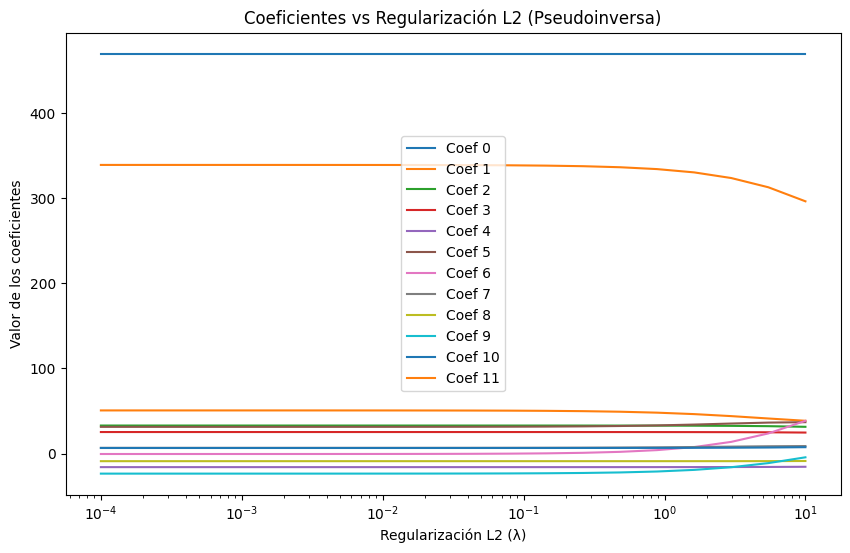

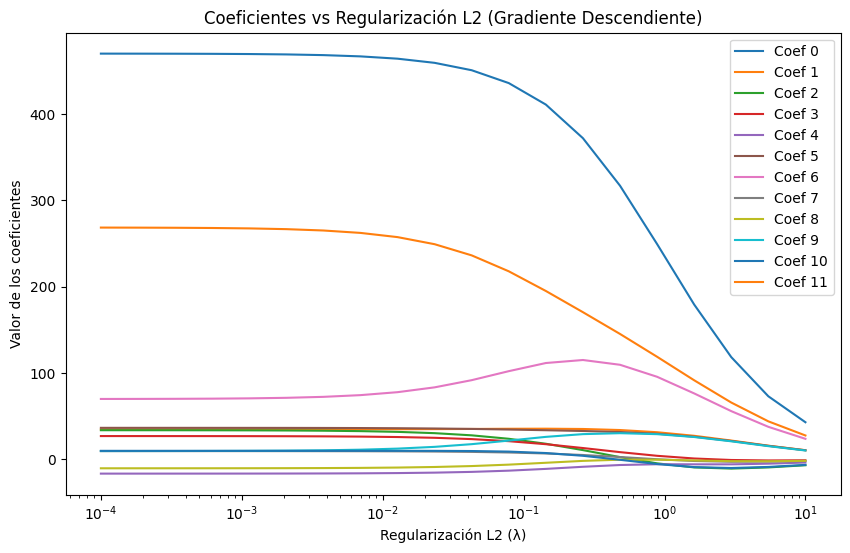

In [11]:
from utils import graficar_coef_vs_l
graficar_coef_vs_l(xn_train, dy_train, "L2")

En el caso de la **Pseudoinversa**, los coeficientes se mantienen relativamente estables, aunque para valores elevados de lambda, los coeficientes altos tienden a bajar y los bajos a subir ligeramente.  

Por otro lado, en **Gradiente Descendiente**, los coeficientes se acercan a cero con el aumento de lambda. Sin embargo, no incrementamos más lambda porque, al hacerlo, los valores se disparaban y el gráfico se volvía inentendible.   

A continuación, realizaremos el mismo análisis con **regularización L1 (Lasso)**, pero solo con **Gradiente Descendiente**, ya que la Pseudoinversa no es compatible con esta técnica.

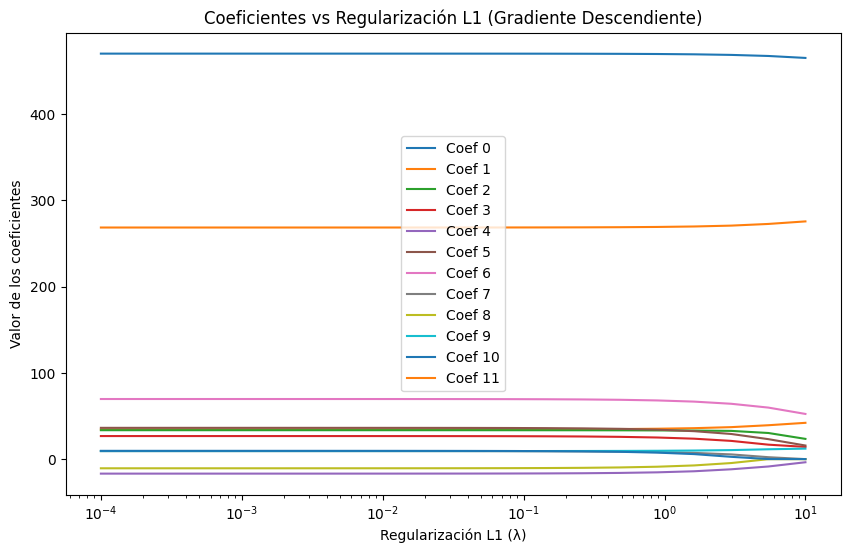

In [12]:
graficar_coef_vs_l(xn_train, dy_train, "L1")

A diferencia de la regularización L2, en este caso los coeficientes se reducen de forma más progresiva a medida que aumenta lambda. No se observa una disminución abrupta, ya que los coeficientes no tienden a cero de manera agresiva. Esto indica que, en el rango evaluado, la regularización L1 no está forzando una selección estricta de variables.  

Observando los gráficos obtenidos, decidimos probar un modelo con regularización L2 utilizando **λ = 0.1**. En este punto, los coeficientes en **Gradiente Descendiente** comienzan a mostrar cambios notorios, mientras que en **Pseudoinversa** todavía se mantienen relativamente estables. Esto sugiere que es un valor donde la regularización empieza a tener un efecto significativo en Gradiente Descendiente sin que los coeficientes se vuelvan inestables, permitiendo evaluar su impacto en el ajuste del modelo.

In [18]:
metricas(xn_train, dy_train, xn_val, dy_val, amanda, L1=0, L2=0.1)


--- Comparación de métodos ---

Gradiente descendiente:
MSE Train: 9522.3022 | MSE Validation: 5236.3074
RMSE Train: 97.5823 | RMSE Validation: 72.3623
MAE Train: 53.6939 | MAE Validation: 47.1956
Predicción de price: [605.4295233]

Pseudoinversa:
MSE Train: 6026.2974 | MSE Validation: 3127.0299
RMSE Train: 77.6292 | RMSE Validation: 55.9199
MAE Train: 46.3259 | MAE Validation: 42.0247
Predicción de price: [557.85092292]


Los resultados muestran que la **Pseudoinversa** no experimentó un cambio significativo en su error, manteniéndose en valores similares a los obtenidos sin regularización. En cambio, **Gradiente Descendiente** sufrió un aumento considerable en su error, lo que indica que la elección de λ impactó fuertemente su desempeño.

La regularización L2 beneficia a la regresión al reducir la varianza del modelo y controlar el sobreajuste, estabilizando los coeficientes y evitando que adquieran valores extremos. Sin embargo, si el valor de λ es demasiado alto, puede penalizar excesivamente los coeficientes y perjudicar la capacidad del modelo para ajustarse a los datos, como ocurrió en Gradiente Descendiente en este caso.

Ahora realizaremos un barrido del hiperparámetro λ, evaluando su impacto en el error cuadrático medio (ECM) sobre el conjunto de validación. Esto nos permitirá analizar cómo varía el desempeño del modelo en función de la regularización y determinar un valor óptimo de λ.


In [20]:
import numpy as np
lambdas = np.logspace(-1, 1, 6)
for lamb in lambdas:
    metricas(xn_train, dy_train, xn_val, dy_val, amanda, L1=0, L2=lamb)
    print("\n Valor de Lambda", lamb)


--- Comparación de métodos ---

Gradiente descendiente:
MSE Train: 9522.3022 | MSE Validation: 5236.3074
RMSE Train: 97.5823 | RMSE Validation: 72.3623
MAE Train: 53.6939 | MAE Validation: 47.1956
Predicción de price: [605.4295233]

Pseudoinversa:
MSE Train: 6026.2974 | MSE Validation: 3127.0299
RMSE Train: 77.6292 | RMSE Validation: 55.9199
MAE Train: 46.3259 | MAE Validation: 42.0247
Predicción de price: [557.85092292]

 Valor de Lambda 0.1

--- Comparación de métodos ---

Gradiente descendiente:
MSE Train: 18707.9663 | MSE Validation: 12671.5677
RMSE Train: 136.7771 | RMSE Validation: 112.5681
MAE Train: 95.2984 | MAE Validation: 86.5333
Predicción de price: [563.11051353]

Pseudoinversa:
MSE Train: 6026.4498 | MSE Validation: 3123.9933
RMSE Train: 77.6302 | RMSE Validation: 55.8927
MAE Train: 46.3309 | MAE Validation: 42.0079
Predicción de price: [558.59901231]

 Valor de Lambda 0.251188643150958

--- Comparación de métodos ---

Gradiente descendiente:
MSE Train: 49026.0278 | MSE 

Se observa que la regularización L2 impacta de manera diferente en cada método. En el caso de la **Pseudoinversa**, los resultados se mantienen estables a lo largo de los distintos valores de λ, con variaciones mínimas en los errores y predicciones. Esto indica que la regularización no afecta significativamente el ajuste del modelo en este caso.

Por otro lado, en **Gradiente Descendiente**, la inclusión de regularización L2 genera un incremento progresivo en los errores, tanto en el conjunto de entrenamiento como en el de validación. A medida que λ aumenta, los coeficientes se ven más afectados, lo que lleva a un deterioro en el desempeño del modelo y una desviación en las predicciones. 

Este comportamiento muestra que la regularización L2 impone restricciones en la magnitud de los coeficientes, evitando el sobreajuste, pero si se aplica en exceso puede llevar a una pérdida significativa de información relevante, deteriorando la capacidad predictiva del modelo.

Probaremos evaluar el ECM mediante validación cruzada y graficaremos la variación del ECM en función del coeficiente de regularización para analizar su impacto en el modelo.

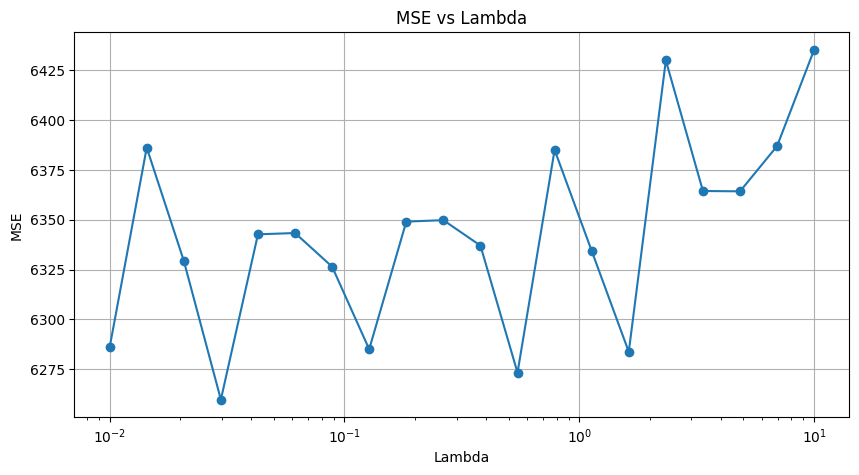

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from data_splitting import cross_val
lambdas = np.logspace(-2, 1, 20)
mses = []
for lamb in lambdas:
    mse = cross_val(xn_train, dy_train, l2=lamb)
    mses.append(mse)
plt.figure(figsize=(10, 5))
plt.plot(lambdas, mses, marker="o")
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("MSE")
plt.title("MSE vs Lambda")
plt.grid()
plt.show()

El gráfico muestra la variación del ECM en función del coeficiente de regularización λ, evaluado mediante validación cruzada. Se observa que el error no sigue una tendencia completamente monótona, sino que presenta fluctuaciones a lo largo del rango de valores de λ explorado.

Para valores muy pequeños de λ, el ECM es relativamente bajo, lo que indica que la regularización tiene un impacto reducido en la estimación de los coeficientes. A medida que λ aumenta, el ECM experimenta variaciones y, en ciertos puntos, incrementos significativos, lo que sugiere que una regularización excesiva puede perjudicar el desempeño del modelo.

En particular, se observa que existen valores intermedios de λ donde el ECM es menor, lo que sugiere que hay un punto óptimo de regularización que permite mejorar la capacidad predictiva del modelo sin introducir una penalización excesiva. 

Con base en este análisis, se puede seleccionar un valor adecuado de λ que minimice el ECM y proporcione un equilibrio entre sesgo y varianza.

6.1) De todos los modelos realizados hasta ahora, ¿cuál seleccionaría para implementar en
producción? Justifique su respuesta.


6.2) Para evaluar la capacidad predictiva del modelo seleccionado, compute y reporte el
MAE (Mean Average Error ) y RMSE (Root Mean Squared Error ) sobre el conjunto
de prueba.